In [4]:
# Mount Google Drive (restart runtime if you get authentication errors)
from google.colab import drive
drive.mount('/content/drive')

# Install required packages (restart runtime after installation)
!pip install tensorflow==2.15.0
!pip install scikit-learn matplotlib

# Restart the runtime now (Runtime → Restart runtime)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 94.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempti

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


In [3]:
# Paths to your signature datasets
original_dir = '/content/drive/MyDrive/original/'  # Genuine signatures
forged_dir = '/content/drive/MyDrive/Forged/'     # Forged signatures

# Image dimensions
IMG_WIDTH = 150
IMG_HEIGHT = 150

def load_images(folder_path, label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            try:
                img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='grayscale')
                img_array = img_to_array(img) / 255.0  # Normalize to [0,1]
                images.append(img_array)
                labels.append(label)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
    return images, labels

# Load datasets
original_images, original_labels = load_images(original_dir, 1)  # 1 = Genuine
forged_images, forged_labels = load_images(forged_dir, 0)       # 0 = Forged

# Combine and split into train/validation/test sets
all_images = np.array(original_images + forged_images)
all_labels = np.array(original_labels + forged_labels)

X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

Training samples: 145
Validation samples: 17
Test samples: 41


In [4]:
def make_pairs(images, labels):
    pair_images = []
    pair_labels = []

    # Group indices by class
    class_indices = {}
    for i, label in enumerate(labels):
        if label not in class_indices:
            class_indices[label] = []
        class_indices[label].append(i)

    # Create pairs
    for i in range(len(images)):
        # Positive pair (same class)
        current_label = labels[i]
        other_indices = class_indices[current_label]
        j = random.choice(other_indices)
        while j == i and len(other_indices) > 1:
            j = random.choice(other_indices)
        pair_images.append([images[i], images[j]])
        pair_labels.append(1)  # 1 = Similar

        # Negative pair (different class)
        other_labels = [l for l in class_indices if l != current_label]
        other_label = random.choice(other_labels)
        j = random.choice(class_indices[other_label])
        pair_images.append([images[i], images[j]])
        pair_labels.append(0)  # 0 = Different

    return np.array(pair_images), np.array(pair_labels)

# Generate pairs
train_pairs, train_labels = make_pairs(X_train, y_train)
val_pairs, val_labels = make_pairs(X_val, y_val)
test_pairs, test_labels = make_pairs(X_test, y_test)

print(f"Training pairs: {len(train_pairs)}")
print(f"Validation pairs: {len(val_pairs)}")
print(f"Test pairs: {len(test_pairs)}")

Training pairs: 290
Validation pairs: 34
Test pairs: 82


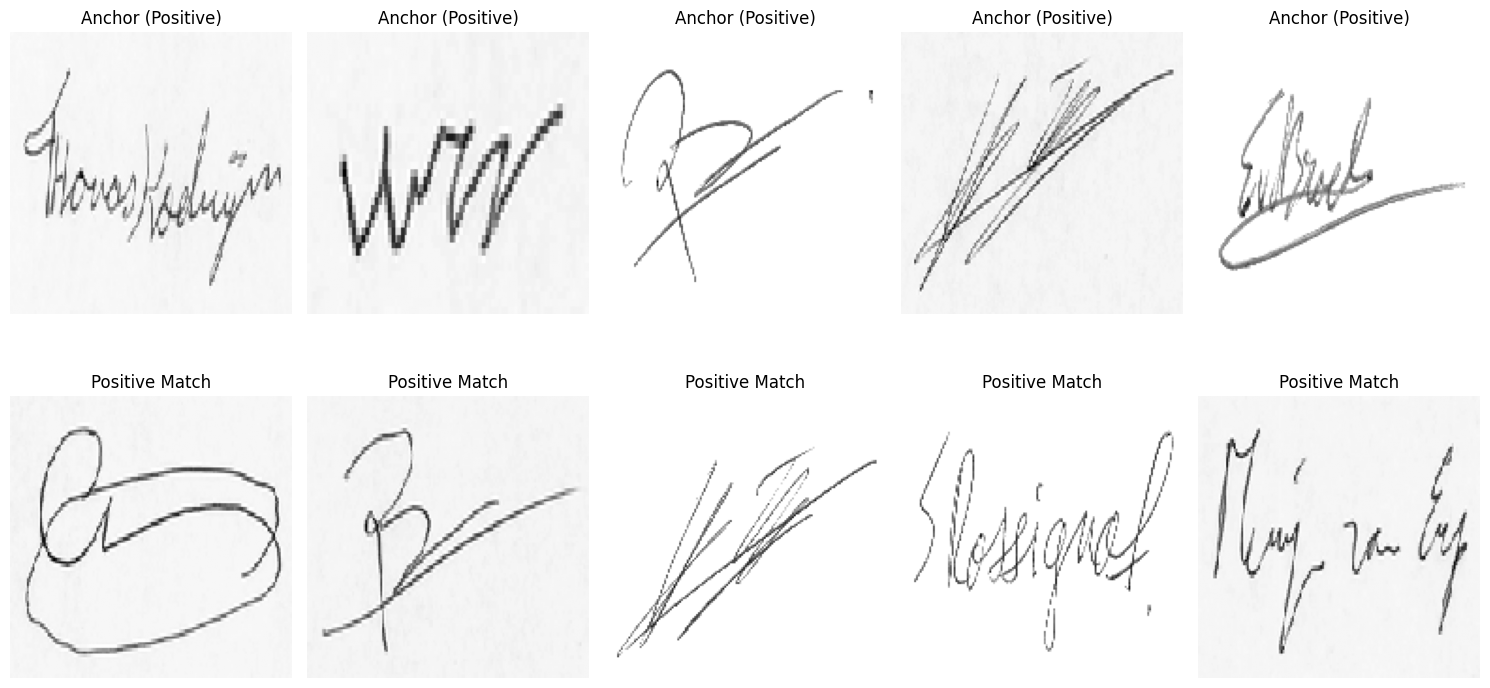

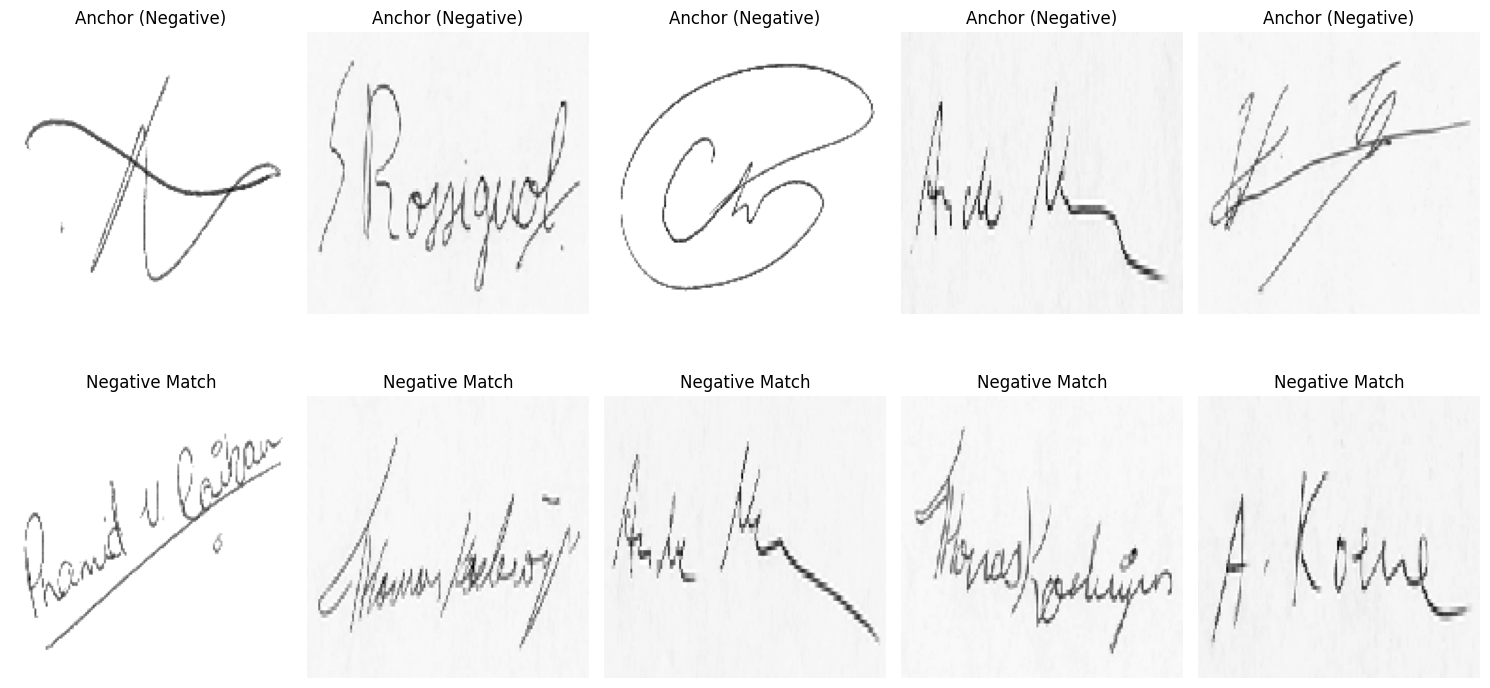

In [12]:
def visualize_pairs(pairs, labels, num_samples=5):
    plt.figure(figsize=(15, 8))

    # Display positive pairs
    for i in range(num_samples):
        idx = random.choice(np.where(labels == 1)[0])
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(np.squeeze(pairs[idx][0]), cmap='gray')
        plt.title("Anchor (Positive)")
        plt.axis('off')

        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(np.squeeze(pairs[idx][1]), cmap='gray')
        plt.title("Positive Match")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Display negative pairs in a separate figure
    plt.figure(figsize=(15, 8))
    for i in range(num_samples):
        idx = random.choice(np.where(labels == 0)[0])
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(np.squeeze(pairs[idx][0]), cmap='gray')
        plt.title("Anchor (Negative)")
        plt.axis('off')

        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(np.squeeze(pairs[idx][1]), cmap='gray')
        plt.title("Negative Match")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
visualize_pairs(train_pairs, train_labels)

In [13]:
def build_siamese_network(input_shape):
    input = layers.Input(input_shape)
    x = layers.Conv2D(64, (3, 3), activation='relu')(input)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(256, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    return Model(input, x)

# Input shape
input_shape = (IMG_HEIGHT, IMG_WIDTH, 1)

# Build the Siamese Network
base_network = build_siamese_network(input_shape)

# Inputs
input_a = layers.Input(shape=input_shape)
input_b = layers.Input(shape=input_shape)

# Feature encodings
encoded_a = base_network(input_a)
encoded_b = base_network(input_b)

# Distance computation (Manhattan distance)
distance = layers.Lambda(lambda x: tf.abs(x[0] - x[1]))([encoded_a, encoded_b])

# Output (similarity score)
output = layers.Dense(1, activation='sigmoid')(distance)

# Final model
siamese_network = Model(inputs=[input_a, input_b], outputs=output)

# Compile
siamese_network.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

siamese_network.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 150, 1)]        0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 150, 150, 1)]        0         []                            
                                                                                                  
 model (Functional)          (None, 512)                  3824998   ['input_2[0][0]',             
                                                          4          'input_3[0][0]']             
                                                                                                  
 lambda (Lambda)             (None, 512)                  0         ['model[0][0]',         

In [20]:
siamese_network.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [23]:
history = siamese_network.fit(
    [train_pairs[:, 0], train_pairs[:, 1]],
    train_labels,
    validation_data=([val_pairs[:, 0], val_pairs[:, 1]], val_labels),
    batch_size=32,
    epochs=50,
    callbacks=[early_stopping]
)


Epoch 1/50
10/10 [==============================] - 20s 2s/step - loss: 0.6263 - accuracy: 0.7448 - val_loss: 0.6840 - val_accuracy: 0.4118
Epoch 2/50
10/10 [==============================] - 22s 2s/step - loss: 0.5956 - accuracy: 0.7655 - val_loss: 0.6782 - val_accuracy: 0.4118
Epoch 3/50
10/10 [==============================] - 20s 2s/step - loss: 0.5595 - accuracy: 0.7759 - val_loss: 0.6890 - val_accuracy: 0.5000
Epoch 4/50
10/10 [==============================] - 21s 2s/step - loss: 0.5194 - accuracy: 0.7966 - val_loss: 0.7063 - val_accuracy: 0.4706
Epoch 5/50
10/10 [==============================] - 22s 2s/step - loss: 0.4503 - accuracy: 0.8379 - val_loss: 0.7290 - val_accuracy: 0.5294
Epoch 6/50
10/10 [==============================] - 20s 2s/step - loss: 0.3378 - accuracy: 0.9000 - val_loss: 0.7331 - val_accuracy: 0.5588
Epoch 7/50
10/10 [==============================] - 23s 2s/step - loss: 0.2360 - accuracy: 0.9379 - val_loss: 0.7376 - val_accuracy: 0.5294
Epoch 8/50
10/10 [==

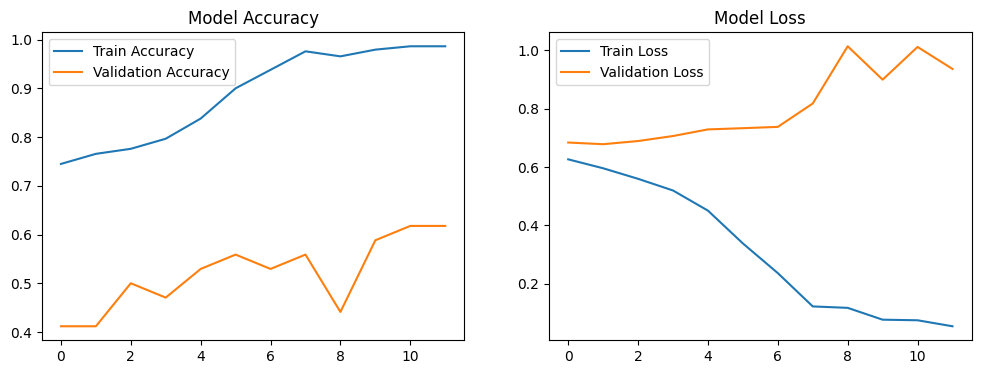

3/3 [==============================] - 2s 610ms/step - loss: 0.7055 - accuracy: 0.5122
Test Accuracy: 0.5122


In [26]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.legend()
    plt.show()

plot_history(history)
# Evaluate on test set
test_loss, test_acc = siamese_network.evaluate(
    [test_pairs[:, 0], test_pairs[:, 1]], test_labels
)

print(f"Test Accuracy: {test_acc:.4f}")


In [35]:
def verify(model, ref_img, test_img, threshold=0.5):
    IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
    ref = load_img(ref_img, target_size=IMG_SIZE, color_mode='grayscale')
    test = load_img(test_img, target_size=IMG_SIZE, color_mode='grayscale')

    ref_arr = img_to_array(ref)/255.0
    test_arr = img_to_array(test)/255.0

    # Reshape the input images to match the expected shape (150, 150, 1)
    ref_arr = ref_arr.reshape(1, IMG_HEIGHT, IMG_WIDTH, 1)
    test_arr = test_arr.reshape(1, IMG_HEIGHT, IMG_WIDTH, 1)

    similarity = model.predict([ref_arr, test_arr])[0][0]

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(ref)
    plt.title("Reference")

    plt.subplot(1,2,2)
    plt.imshow(test)
    plt.title(f"Test\nSimilarity: {similarity:.2f}")

    return similarity > threshold

1/1 [==============================] - 0s 182ms/step


True

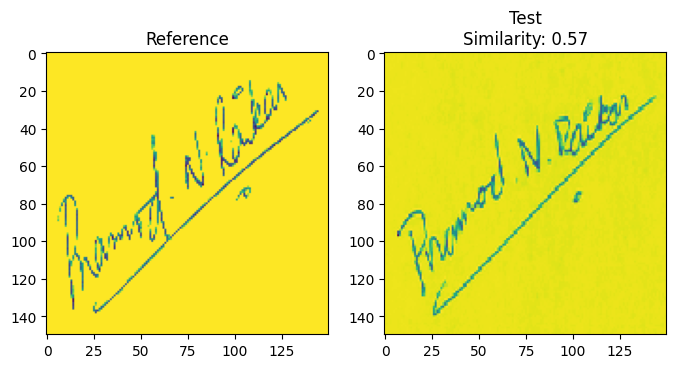

In [36]:
verify(
    siamese_network,
    "/content/drive/MyDrive/original/00201002.png",  # Reference (must be genuine)
    "/content/drive/MyDrive/Forged/02100002.png"        # Test (can be genuine or forged)
)

1/1 [==============================] - 0s 54ms/step


False

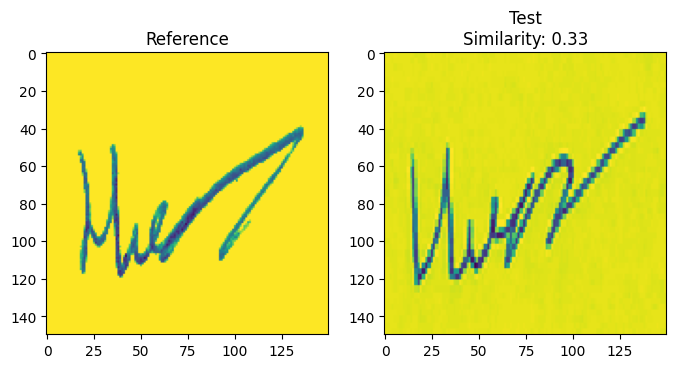

In [37]:
verify(
    siamese_network,
    "/content/drive/MyDrive/original/01202012.png",  # Reference (must be genuine)
    "/content/drive/MyDrive/Forged/02102012.png"        # Test (can be genuine or forged)
)